all data can be downloaded here: https://eerscmap.usgs.gov/uswtdb/data/
data explained here: https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdb_v3_1_20200717.xml

Key
- t_manufacturer: turbine manufacturer - name of the original equipment manufacturer of the turbine
- t_model: turbine model - manufacturer's model name of each turbine
- t_cap: Turbine rated capacity in kilowatt (kW). The manufacturer's stated output power at rated wind speed. 
- t_hub_height: turbine hub height in meters (m)
- t_rotor_d: turbine rotor diameter in meters (m)
- t_rsa: turbine rotor swept area square meters (m^2); calculated as 3.14159 (([rotor_dia] /2)*([rotor_dia] /2)
- t_total_height: turbine total height - height of entire wind turbine from ground to tip of a vertically extended blade above the tower. Computed as the hub height plus half of the rotor diameter, in meters, when t_hh and t_rd are non-missing. Otherwise, the total height as provided by the FAA DOF or FAA OE/AAA is used, which can be considered a maximum height
- t_state: state where turbine is located
- t_conf_atr: level of confidence in the turbine's attributes, from low to high
- t_conf_loc: Level of confidence in turbine location, from low to high

We will explore the relationship between some of the variables down below. 

In [71]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

df_raw = pd.read_csv('uswtdb_v3_1_20200717.csv')
df_raw.head()

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,turbine_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,project_name,year_online,...,t_hub_height,t_rotor_d,t_rsa,t_total_height,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3072677,NaN,NaN,5042.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/18,Digital Globe,-118.365746,35.077869
1,3073412,NaN,NaN,5756.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/18,Digital Globe,-118.355255,35.084801
2,3073335,NaN,NaN,4946.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/18,Digital Globe,-118.357544,35.088322
3,3072695,NaN,NaN,5143.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/18,Digital Globe,-118.364410,35.077435
4,3073327,NaN,NaN,4966.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,NaN,NaN,2,3,5/8/18,Digital Globe,-118.357872,35.084499


In [72]:
df_raw.dtypes

turbine_id          int64
faa_ors            object
faa_asn            object
usgs_pr_id        float64
eia_id            float64
t_state            object
t_county           object
t_fips              int64
project_name       object
year_online       float64
p_tnum              int64
p_cap              object
t_manufacturer     object
t_model            object
t_cap             float64
t_hub_height      float64
t_rotor_d         float64
t_rsa             float64
t_total_height    float64
t_conf_atr          int64
t_conf_loc          int64
t_img_date         object
t_img_srce         object
xlong             float64
ylat              float64
dtype: object

## Data Cleaning

In [81]:
df = df_raw.filter(['t_manufacturer', 't_model', 't_cap', 't_hub_height', 't_rotor_d', 't_rsa', 't_total_height', 't_state', 't_conf_atr', 't_conf_loc'], axis=1)

In [82]:
df.dropna(inplace= True)

In [83]:
df['t_cap'].sort_values().unique()

array([  50.,   65.,  100.,  500.,  550.,  600.,  650.,  660.,  676.,
        700.,  710.,  750.,  850.,  900.,  950., 1000., 1250., 1300.,
       1500., 1600., 1620., 1650., 1670., 1680., 1700., 1800., 1815.,
       1850., 2000., 2050., 2100., 2200., 2300., 2350., 2370., 2400.,
       2500., 2850., 3000., 3075., 3600.])

In [84]:
df['t_rotor_d'].sort_values().unique()

array([ 15. ,  21. ,  40. ,  42. ,  44. ,  45. ,  47. ,  48. ,  50. ,
        52. ,  54. ,  57. ,  58. ,  59. ,  60. ,  61.4,  62. ,  64. ,
        65. ,  66. ,  70. ,  70.5,  72. ,  77. ,  80. ,  82. ,  82.3,
        82.5,  83. ,  85.5,  86.8,  87. ,  87.5,  88. ,  89. ,  90. ,
        91. ,  91.5,  92. ,  92.5,  93. ,  95. ,  96. ,  97. , 100. ,
       101. , 102. , 103. , 108. , 110. , 112. , 116. , 117. , 120. ])

In [85]:
df['t_conf_atr'].sort_values().unique()

array([1, 2, 3])

In [86]:
df['t_conf_loc'].sort_values().unique()

array([3])

In [87]:
df['t_manufacturer'].sort_values().unique()

array(['AAER', 'AOC', 'Acciona', 'Alstom', 'Bonus',
       'Changzhou Railcar Propulsion Engineering Research and Development Center',
       'China Creative Wind Energy', 'Clipper', 'DeWind', 'EWT', 'Enron',
       'Entegrity', 'Fuhrlander', 'GE Wind', 'Gamesa', 'Goldwind',
       'Guodian', 'Hyundai', 'Mitsubishi', 'NEG Micon', 'NedWind',
       'Nordex', 'Nordic', 'Northern Power Systems', 'REpower', 'RRB',
       'Samsung', 'Sany', 'Siemens', 'Siemens Gamesa Renewable Energy',
       'Sinovel', 'Suzlon', 'Unison', 'Vensys', 'Vestas',
       'Vestas North America', 'Zond'], dtype=object)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21878 entries, 170 to 60712
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   t_manufacturer  21878 non-null  object 
 1   t_model         21878 non-null  object 
 2   t_cap           21878 non-null  float64
 3   t_hub_height    21878 non-null  float64
 4   t_rotor_d       21878 non-null  float64
 5   t_rsa           21878 non-null  float64
 6   t_total_height  21878 non-null  float64
 7   t_state         21878 non-null  object 
 8   t_conf_atr      21878 non-null  int64  
 9   t_conf_loc      21878 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.8+ MB


## Single Variate Regression

Explore the relationship of turbine rotor diameter on turbine rated capacity using Ordinary Least Sqaures method.

In [89]:
df['intercept'] = 1
lm = sm.OLS(df['t_cap'], df[['intercept', 't_rotor_d']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  t_cap   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 4.030e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:32:00   Log-Likelihood:            -1.5567e+05
No. Observations:               21878   AIC:                         3.114e+05
Df Residuals:                   21876   BIC:                         3.114e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -539.6559     11.371    -47.461      0.000    -561.943    -517.369
t_rotor_d     26.7385      0.133    200.756      0.000      26.477      27.000
==============================================================================
Omnibus:                     4876.271   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15048.561
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       6.356   Cond. No.                         482.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


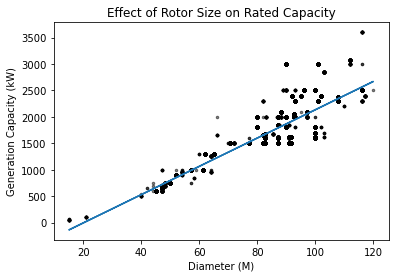

In [90]:
N = len(df)
x = df['t_rotor_d']
y = df['t_cap']
colors = (0,0,0)
area = np.pi*2

# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Effect of Rotor Size on Rated Capacity')
plt.xlabel('Diameter (M)')
plt.ylabel('Generation Capacity (kW)')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.show()

## Multivariate Regression 

### with quantitative data only

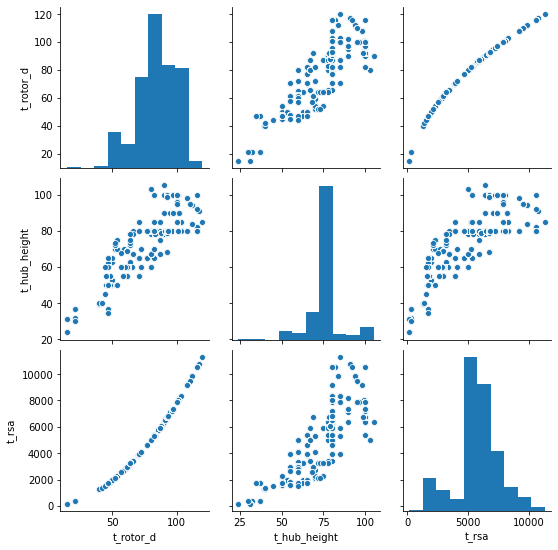

In [91]:
sb.pairplot(df[[ 't_rotor_d', 't_hub_height', 't_rsa']])

In [92]:
df['intercept'] = 1
lm = sm.OLS(df['t_cap'], df[['intercept', 't_hub_height', 't_rsa']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  t_cap   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 1.844e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:32:04   Log-Likelihood:            -1.5629e+05
No. Observations:               21878   AIC:                         3.126e+05
Df Residuals:                   21875   BIC:                         3.126e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      371.5719     17.823     20.848      0.000     336.638     406.506
t_hub_height     1.8732      0.284      6.597      0.000       1.317       2.430
t_rsa            0.2077      0.001    139.369      0.000       0.205       0.211
==============================================================================
Omnibus:                     4329.842   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12593.838
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                       6.081   Cond. No.                     5.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

the variance inflation factors indicated very strong multicolleriatybetwen the variable since they are all bigger than 10


In [93]:
# let's take a look at VIFs Variance Inflation Factor
y, X = dmatrices('t_cap ~ t_rsa + t_hub_height', df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,74.004500,Intercept
1,1.782427,t_rsa
2,1.782427,t_hub_height


### with categorical data 

In [94]:
# see list of turbine manufacturer in CA
df.groupby(['t_state', 't_manufacturer' ]).size()['CA'].sort_values()

t_manufacturer
NEG Micon       1
AAER            2
Zond            5
Clipper         8
NedWind        13
Gamesa         65
Siemens       191
Mitsubishi    226
REpower       245
Vestas        567
GE Wind       570
dtype: int64

In [95]:
#create dataframe for turbine in CA only
df['CA'] = np.where(df['t_state']== 'CA', True, False)
df_CA_manu = df.loc[df['CA'] == True]

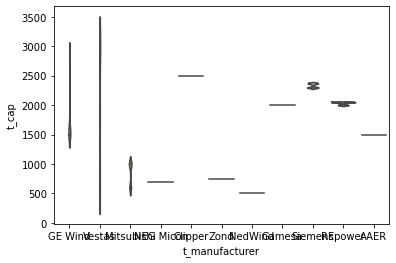

In [101]:
# t_manufacturer  using violin plots
df_CA_manu5 = df_CA_manu

sb.violinplot(data=df_CA_manu, x='t_manufacturer', y='t_cap', inner = 'quartile');

(-16.95518628815111, 3676.955186288151)

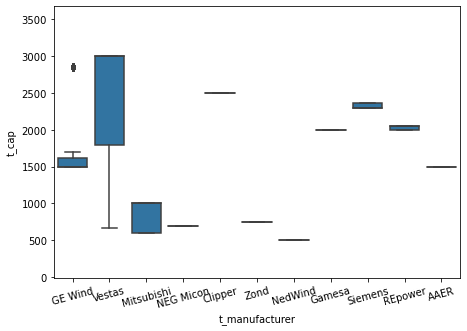

In [103]:
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

ax1 = sb.violinplot(data=df_CA_manu, x='t_manufacturer', y='t_cap', color=base_color, innner='quartile')
plt.xticks(rotation=15);

plt.subplot(1, 2, 2)
sb.boxplot(data=df_CA_manu, x='t_manufacturer', y='t_cap', color=base_color)
plt.xticks(rotation=15);
plt.ylim(ax1.get_ylim()) 

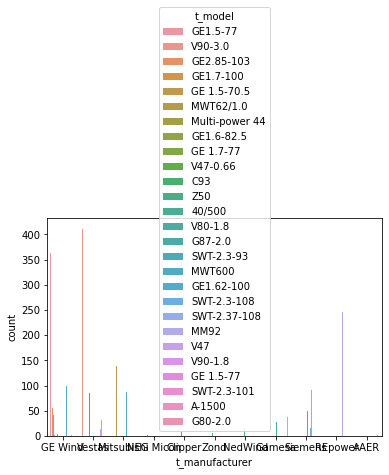

In [109]:
#clustered bar charts: try to plot the 3 most common turbine in the top 5 states with turbines, 
# and shw the count for each manufacturer
sb.countplot(data=df_CA_manu, x='t_manufacturer', hue='t_model');

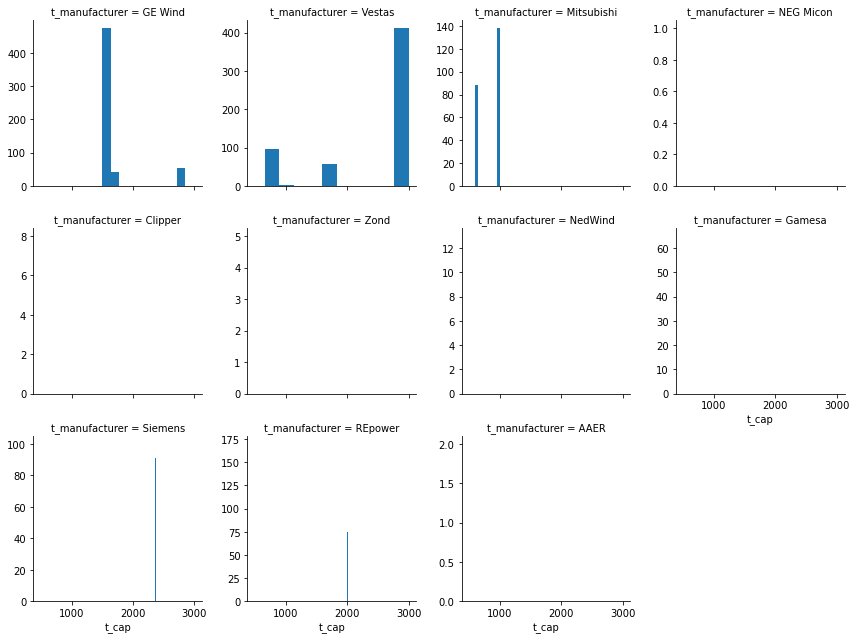

In [115]:
# Facet grids
g = sb.FacetGrid(data = df_CA_manu, col = 't_manufacturer', col_wrap=4, sharey=False)
g.map(plt.hist, "t_cap");

In [312]:
df_CA_manu[['AAER', 'Bonus','Clipper', 'Danwin', 'GE Wind', 'Gamesa','Mitsubishi', 'NEG Micon', 'NedWind','Nordtank','Norwin','REpower', 'Siemens', 'Vestas', 'Vestas North America','Zond']] = pd.get_dummies(df_CA_manu['t_manufacturer'])

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [315]:
df_CA_manu['intercept'] = 1
lm = sm.OLS(df_CA_manu['t_cap'], df_CA_manu[['intercept', 'AAER', 'Bonus','Clipper', 'Danwin', 'GE Wind', 'Gamesa',
       'Mitsubishi', 'NEG Micon', 'NedWind','Nordtank','Norwin',
       'REpower', 'Siemens','Vestas North America','Zond']])
results = lm.fit()
results.summary()
#Vestas is baseline. this will tell us how all the other turbine compare to the Vestas turbine, which are the most 
# frequently installed turbine in CA

<ipython-input-315-be0394973ea0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CA_manu['intercept'] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  t_cap   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     80.03
Date:                Mon, 28 Sep 2020   Prob (F-statistic):          2.60e-214
Time:                        13:18:10   Log-Likelihood:                -32748.
No. Observations:                3967   AIC:                         6.553e+04
Df Residuals:                    3951   BIC:                         6.563e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             1385.9717     22.204     62.421      0.000    1342.440    1429.504
AAER                   114.0283    539.023      0.212      0.832    -942.762    1170.818
Bonus                -1280.8365    110.688    -11.572      0.000   -1497.848   -1063.825
Clipper               1114.0283    330.549      3.370      0.001     465.965    1762.092
Danwin               -1225.9717     89.775    -13.656      0.000   -1401.982   -1049.961
GE Wind                311.5693     38.884      8.013      0.000     235.336     387.803
Gamesa                 614.0283    103.587      5.928      0.000     410.940     817.117
Mitsubishi            -528.5459     58.007     -9.112      0.000    -642.273    -414.819
NEG Micon             -697.8251     89.411     -7.805      0.000    -873.122    -522.528
NedWind               -885.9717    259.670     -3.412      0.001   -1395.071    -376.872
Nordtank             -1320.9717    111.414    -11.856      0.000   -1539.405   -1102.538
Norwin               -1160.9717    933.088     -1.244      0.213   -2990.350     668.407
REpower                648.7222     63.598     10.200      0.000     524.035     773.410
Siemens                941.4450     64.177     14.670      0.000     815.622    1067.268
Vestas North America  1614.0283    933.088      1.730      0.084    -215.350    3443.407
Zond                  -635.9717    112.910     -5.633      0.000    -857.340    -414.603
==============================================================================
Omnibus:                      199.393   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.366
Skew:                           0.571   Prob(JB):                     1.90e-49
Kurtosis:                       2.766   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's take a look at our top three most installed turbines: Vestas, GE Wind, and Mitsubishi. So for a Vestas turbine, we predict that the rated capacity is 1386kWs. And for example, a GE Wind turbine is predicted to be 312kWs more than a Vestas, whereas a Mitsubishi is predicted to be 528 less than a Vestas. 

## Logistic Regression (Logit)

In this example, we will treat the t_conf_atr which is the confidence lvel in the accuracy of the attribute like a categorical variable. Since there are three [1, 2, 3] which are equivalent to [low, medium, high]. 

We will use the attribute confidence to predict whether this turbine is in CA. 

The question we will mark here is whether the turbines in CA tend to have a high level of confidence in the data attributes. So if the data for the turbines in CA reliable?

In [318]:
df.head()

,t_manufacturer,t_model,t_cap,t_hub_height,t_rotor_d,t_rsa,t_total_height,t_state,t_conf_atr,t_conf_loc,intercept,CA
160,Nordex,AW125/3000,3000.0,87.5,125.0,12271.85,150.0,IA,3,3,1,False
161,Nordex,AW125/3000,3000.0,87.5,125.0,12271.85,150.0,IA,3,3,1,False
162,Nordex,AW125/3000,3000.0,87.5,125.0,12271.85,150.0,IA,3,3,1,False
163,Nordex,AW125/3000,3000.0,87.5,125.0,12271.85,150.0,IA,3,3,1,False
164,Nordex,AW125/3000,3000.0,87.5,125.0,12271.85,150.0,IA,3,3,1,False


let's use our 'CA' column again to fit a logistic regression model where we would like to predict if a turbine in in CA or not.

In [321]:
df[['not_CA','CA']] = pd.get_dummies(df['CA'])

In [322]:
df = df.drop('not_CA', axis=1)

In [324]:
print(df['CA'].mean())
print(df.groupby('CA').mean()['t_cap'])

0.06838240364062607
CA
0    1886.312684
1    1406.867910
Name: t_cap, dtype: float64


In [337]:
df['intercept'] = 1
log_mod = sm.Logit(df['CA'], df[['intercept','t_cap', 't_hub_height','t_rotor_d', 't_rsa', 't_total_height', 't_conf_atr' ]])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/opt/miniconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/miniconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/miniconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:                Logit            Pseudo R-squared: inf   
Dependent Variable:   CA               AIC:              inf   
Date:                 2020-09-28 14:04 BIC:              inf   
No. Observations:     58012            Log-Likelihood:   -inf  
Df Model:             6                LL-Null:          0.0000
Df Residuals:         58005            LLR p-value:      1.0000
Converged:            1.0000           Scale:            1.0000
No. Iterations:       8.0000                                   
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
intercept       5.8100   0.1898  30.6071 0.0000  5.4380  6.1821
t_cap           0.0031   0.0001  53.5322 0.0000  0.0030  0.0032
t_hub_height   -0.4877   0.1325  -3.6815 0.0002 -0.7474 -0.2281
t_rotor_d      -0.1590   0.0670  -2.3744 0.0176 -0.2903 -0.0278
t_rsa          -0.0005   0.0000 -13.5238 0.0000 -0.0006 -0.0005
t_total_height  0.3378   0.1324   2.5510 0.0107  0.0783  0.5974
t_conf_atr     -0.2476   0.0585  -4.2287 0.0000 -0.3623 -0.1328
===============================================================

"""

In [335]:
np.exp(results.params)

intercept         44.207940
t_hub_height       1.024839
t_rotor_d          1.171752
t_rsa              0.999581
t_total_height     0.851175
t_conf_atr         0.873282
dtype: float64

In [336]:
1/_

intercept         0.022620
t_hub_height      0.975763
t_rotor_d         0.853423
t_rsa             1.000420
t_total_height    1.174846
t_conf_atr        1.145106
dtype: float64